# NEURAL NETS ON INTERESTED-OR-NOT DATA

## V1: MLP

### PREPROCESSING

In [182]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.porter import PorterStemmer
from functools import partial
from collections import Counter

In [196]:
# LOAD DATA
import os
os.chdir('/Users/jacobsw/Desktop/CLASSIFICATIONS/DATA')
sa_jacob = pd.read_excel('sentiment_jacob.xlsx')
sa_jacob[1][472] = 1.0
data = sa_jacob.ix[:,[0,1]]
data.head()

/Users/jacobsw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,0,1
0,She has indeed contacted me I have n't contact...,2.0
1,The round of interviews went very well . Still...,2.0
2,It looks like my first reply might not have go...,2.0
3,We will be in Austin May NUMBER for the next r...,2.0
4,- MLS # NUMBER is by far my top choice because...,2.0


In [197]:
X, y = data[0].values, data[1].values
print X[0]
print y[0]

She has indeed contacted me I have n't contacted her back because I 'm waiting to hear more about my husband 's job opportunity . He will be flying to Austin the day after Easter to continue the interviews and after that we should know more . If you could tell her that I will gladly contact her after that set of interviews that would be great
2.0


In [198]:
# TEXT PREPROCESSING FUNCTIONS
def josh_tokenize(sent): # tokenizing.
    return re.findall(r"(?u)\b[\w\-']+\b", sent)
def sent_process(sent): # tokenizing, lowercasing, lemmatizing.
    porter = PorterStemmer()
    return [str(porter.stem(token)) for token in josh_tokenize(sent.lower())]
from nltk.corpus import stopwords
stopwords = [PorterStemmer().stem(w) for w in stopwords.words('english')]
def stopwords_remove(sent): # assuming lemmatization, sent is a list of words.
    return [w for w in sent if w not in stopwords]
def int_featurize(vocab, word): # takes a word, returns its index in vocab.
    if word not in vocab: return -1
    else: return vocab.index(word)
def featurize(vocab, sent): # takes a string, returns int-featured vector.
    sent = sent_process(str(sent)) # to a list of preprocessed words.
    return map(partial(int_featurize, vocab), sent)

In [199]:
# CREATE VOCAB
tokensAll = []
for sent in X:
    tokensAll.extend(sent_process(sent)) # 28153.
tokensAll = stopwords_remove(tokensAll) # 15690.
vocab = list(set(tokensAll)) # 2142.

In [200]:
# FEATURIZE DATA
X = map(sent_process, X) # tokenizing, lowercasing, lemmatizing.
X = map(partial(featurize, vocab), X) # featurizing.

Average Sentence Length: 56.31


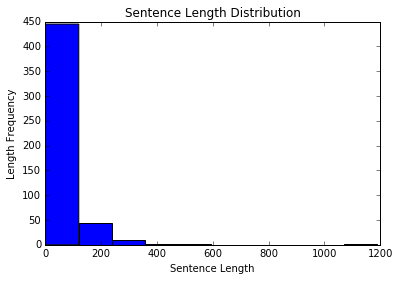

In [201]:
# SENTENCE LENGTH SUMMARY
sentLens = [len(sent) for sent in X]
print 'Average Sentence Length: %.2f' % np.mean(sentLens)
plt.hist(sentLens)
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Length Frequency')
plt.show()

### MODEL BUILDING, TRAINING, EVALUATING

In [202]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

In [203]:
# TRAIN-TEST SPLIT & PADDING
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
np.random.seed(0)
maxWords = int(np.mean(sentLens))
X_train = sequence.pad_sequences(X_train, maxlen=maxWords)
X_test = sequence.pad_sequences(X_test, maxlen=maxWords)

In [206]:
# MODEL BUILDING
model = Sequential()
model.add(Embedding(len(vocab), 56, input_length=maxWords))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_8 (Embedding)            (None, 56, 56)      119952      embedding_input_8[0][0]          
____________________________________________________________________________________________________
flatten_7 (Flatten)                (None, 3136)        0           embedding_8[0][0]                
____________________________________________________________________________________________________
dense_13 (Dense)                   (None, 250)         784250      flatten_7[0][0]                  
____________________________________________________________________________________________________
dense_14 (Dense)                   (None, 3)           753         dense_13[0][0]                   
Total params: 904955
______________________________________________________________________

In [207]:
%%time
# MODEL RUNNING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

Train on 375 samples, validate on 125 samples
Epoch 1/2
375/375 [==============================] - 0s - loss: 1.0522 - acc: 0.4773 - val_loss: 0.9175 - val_acc: 0.6160
Epoch 2/2
375/375 [==============================] - 0s - loss: 0.9158 - acc: 0.6027 - val_loss: 0.8708 - val_acc: 0.6160
Accuracy: 61.60%
CPU times: user 1.49 s, sys: 35.2 ms, total: 1.53 s
Wall time: 1.39 s


## V2: CNN

In [208]:
import numpy as np
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.preprocessing import sequence

In [209]:
# MODEL BUILDING
model = Sequential()
model.add(Embedding(len(vocab), 56, input_length=maxWords))
model.add(Convolution1D(nb_filter=56, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
embedding_9 (Embedding)            (None, 56, 56)      119952      embedding_input_9[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 56, 56)      9464        embedding_9[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)      (None, 28, 56)      0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_8 (Flatten)                (None, 1568)        0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

In [210]:
%%time
# MODEL RUNNING & EVALUATION
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print 'Accuracy: %.2f%%' % (scores[1]*100)

Train on 375 samples, validate on 125 samples
Epoch 1/2
375/375 [==============================] - 0s - loss: 1.0709 - acc: 0.4613 - val_loss: 0.9977 - val_acc: 0.5360
Epoch 2/2
375/375 [==============================] - 0s - loss: 0.9840 - acc: 0.5067 - val_loss: 0.9308 - val_acc: 0.5360
Accuracy: 53.60%
CPU times: user 2.64 s, sys: 337 ms, total: 2.98 s
Wall time: 15.8 s
